#                 TECHNICAL INDICATOR DESIGN AND ANALYSIS
Since major challenge while placing any trade is to predict the future price of the stock, this project uses OHLV(Open price of the same day while High, Low, Volume of the previous day) data to predict C(Close price of the day) using multi regression. Further we have reduced our model to OV to predict C. Moreover, this predicted close price is used to generate trading signals.




In [ ]:
!pip install pandas_market_calendars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.5/105.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 18.1 MB/s eta 0:00:00


In [ ]:
#Importing all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import time
from datetime import datetime
from datetime import timedelta
from datetime import date
import pandas_market_calendars as mcal
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
#Generating a list of trading days for NSE using market calendar
nse = mcal.get_calendar('NSE')

end=date.today()
start=end-timedelta(days=365)

early = nse.schedule(start_date=start, end_date=end)
trading_days=early.axes[0].tolist()
print(len(trading_days))

245


In [ ]:
# Gathering Stock Information
def stock_data(stock,i,trading_days,t):
  stock_data = {}
  volume_data = {}
  end_date=trading_days[i]
  start_date=trading_days[i-(t+2)]

  ticker = yf.Ticker(stock)
  stock_data = ticker.history(start=start_date, end=end_date)[['Close','Open','Volume','Low','High']]

  data = pd.DataFrame(stock_data)
  data['Volume'].shift(1)
  data['Low'].shift(1)
  data['High'].shift(1)
  new_data=data.tail(-1)
  return new_data

**Checking R-Square**

R-squared is the proportion of the variance in the response variable that can be explained by the predictor variables in a linear regression model.  

In [ ]:
#Training model for Reliance over a lookback period of 15 days
data=stock_data("RELIANCE.NS",len(trading_days)-1,trading_days,15)

#Regression equation: Close= β0 + β1 open +β2 high + β3 low + β4 volume + Ε

regr = linear_model.LinearRegression()
X=data[['Open','Volume','Low','High']]
y=data['Close']
regr.fit(X, y)

#Calculating R-square value for the trained model
r_squared = regr.score(X, y)
print("R-squared value is :",r_squared)

#Printing the model constants
print('Intercept :',regr.intercept_)
list(zip(X, regr.coef_))

R-squared value is : 0.9761979633986035
Intercept : -53.92316774487881


[('Open', -0.5341106764874476),
 ('Volume', 1.4563662368172886e-07),
 ('Low', 1.138173150198628),
 ('High', 0.42350228453703576)]

The R-squared of the reduced model turns out to be 0.9762. This means that 97.62% of the variation in the Close price can be explained by the Open, High, Low and Volume of the stock.

After obtaining these results, the test for multicollinearity was conducted since the results cannot be trusted if the independent variables are correlated to one another. To check for multicollinearity Variance Inflation Factor (VIF) test was conducted.

If VIF > 10, then at least one of the variables would be collinear to another.

If VIF < 10, then there would be no collinearity present.

In [ ]:
#Running VIF test over X to check correlation among the independent variables
X = data[['Open','Low','High','Volume']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,Open,45898.276028
1,Low,32427.766438
2,High,46216.501558
3,Volume,9.943793


VIF scores for open, high, and low were greater than 10. This implied that
multicollinearity was present.

This multicollinearity was solved by removing high and low variables.
For this reduced model, we obtained the following VIF.

In [ ]:
#Running VIF test over X of the reduced model
X = data[['Open','Volume']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,Open,9.260661
1,Volume,9.260661


Checking R-squared value for the reduced model and Finding coefficients.

In [ ]:
data=stock_data("RELIANCE.NS",len(trading_days)-1,trading_days,15)

#Regression equation: Close= β0 + β1 open + β2 volume + Ε

regr = linear_model.LinearRegression()
X=data[['Open','Volume']]
y=data['Close']

regr.fit(X, y)

#Calculating R-square value for the reduced model
r_squared = regr.score(X, y)
print("R-squared value is :",r_squared)

#Printing the model coefficients
print('Intercept: ',regr.intercept_)
list(zip(X, regr.coef_))


R-squared value is : 0.8364718877637471
Intercept:  110.52914466959373


[('Open', 0.9582000064687222), ('Volume', -1.0654030200097938e-06)]

The R-squared of the reduced model turns out to be 0.8365. This means that 83.65% of the variation in the Close price can be explained by the Open price and Volume of the stock. Data on closing price,
opening price, highest price, lowest price, and volume of each day is used. It turns out that the
opening price and Volume are the most significant variables while
predicting the closing price of a stock.

#Implementing Indicator Strategy and Analysing Buy Sell Signals

In [ ]:
#Choosing three stocks randomly from Nifty50 stock list
stock_list=['NESTLEIND.NS','NTPC.NS','CIPLA.NS']

In [ ]:
#Gathering information for stock
def stock_data(stock,i,trading_days,t):
  stock_data = {}
  volume_data = {}
  end_date=trading_days[i]
  start_date=trading_days[i-(t+2)]

  ticker = yf.Ticker(stock)
  stock_data = ticker.history(start=start_date, end=end_date)[['Close','Open','Volume','Low','High']]

  data = pd.DataFrame(stock_data)
  data['Volume'].shift(1)
  data['Low'].shift(1)
  data['High'].shift(1)
  new_data=data.tail(-1)
  return new_data

**Indicator Signal**

In the training dataset (data_hist), multiregression is performed and the Root Mean Square Error is calculated.

For the testing dataset (data_curr), the predicted value is assumed to lie between (predicted value ± root mean square error) and thus the conditions are devised accordingly.

If the (pred_value - rms error) > open of the day then there is a strong probability of bullish day.

If the (pred_value + rms error) < open of the day then there is a strong probability of bearish day.

In other cases, there is no potential buy or sell signal, hence hold or no-trade signal is returned.

In [ ]:
#Indicator Signal Function
def indicator(stock,trading_days,i):
  data=stock_data(stock,i,trading_days,t)
  data_curr=data.iloc[-1] #Testing Dataset [Close,Open,Volume]
  data_hist=data[:-1] #Training Dataset
  regr = linear_model.LinearRegression()
  X=data_hist[['Open','Volume']]
  y=data_hist['Close']
  regr.fit(X, y)
  y_pred=regr.predict(X)
  rmse = np.sqrt(metrics.mean_squared_error(y, y_pred)) #Root Mean Square Error in the Training Dataset

  c_pred=regr.predict([[data_curr[1],data_curr[2]]]) #Predicted value using Testing Dataset

  if(c_pred[0] > data_curr[1]):
    if((c_pred[0]-rmse) > data_curr[1]):
      return 1
    else:
      return 0
  elif(c_pred[0] < data_curr[1]):
    if((c_pred[0]+rmse) < data_curr[1]):
      return -1
    else:
      return 0
  else:
    return 0

In [ ]:
#Function to calculate and return daily returns for a stock
def cal_return(stock_list,trading_days,i):
  ticker = yf.Ticker(stock)
  stock_return = ( ticker.history(start=trading_days[i], end=trading_days[i+1])['Close'] -  ticker.history(start=trading_days[i], end=trading_days[i+1])['Open'] ) / ticker.history(start=trading_days[i], end=trading_days[i+1])['Open']

  return stock_return[0]


**Trading Strategy**

Daily square off trading has been implemented using the signal generated by the indicator.

If the signal is 1, long position is assumed when the market opens and square off is done as soon as the market closes.

If the signal is -1, short position is assumed when the market opens and square off is done as soon as the market closes.

If the signal is 0, no trade is placed for that day.

In [ ]:
initial_capital=100000 #Initial Investment
portfolio = {}
t=15 #lookback period for model training
for stock in stock_list:
  portfolio[stock] = initial_capital

trading_returns = []
trading_signals=[]

for i in range(t+2,len(trading_days)-1):
  trade_return = {}
  trade_signal = {}
  for stock in stock_list:
    trade_return[stock] = indicator(stock,trading_days,i) * portfolio[stock] * cal_return(stock,trading_days,i)
    trade_signal[stock] = indicator(stock,trading_days,i)
    portfolio[stock] += trade_return[stock]
  trading_signals.append(trade_signal)
  trading_returns.append(trade_return)

stock_returns = pd.DataFrame(trading_returns, index=trading_days[t+2:len(trading_days)-1])
signal = pd.DataFrame(trading_signals, index=trading_days[t+2:len(trading_days)-1])
stock_returns

,NESTLEIND.NS,NTPC.NS,CIPLA.NS
2023-01-18,-0.000000,0.000000,-0.000000
2023-01-19,-0.000000,-0.000000,0.000000
2023-01-20,-0.000000,706.296051,-0.000000
2023-01-23,608.309659,1515.937632,0.000000
2023-01-24,-566.833343,-0.000000,-0.000000
...,...,...,...
2023-12-15,-0.000000,0.000000,-0.000000
2023-12-18,-0.000000,-0.000000,0.000000
2023-12-19,0.000000,0.000000,0.000000
2023-12-20,2571.094892,-0.000000,-0.000000


**Plotting the PnL chart for the Stocks**

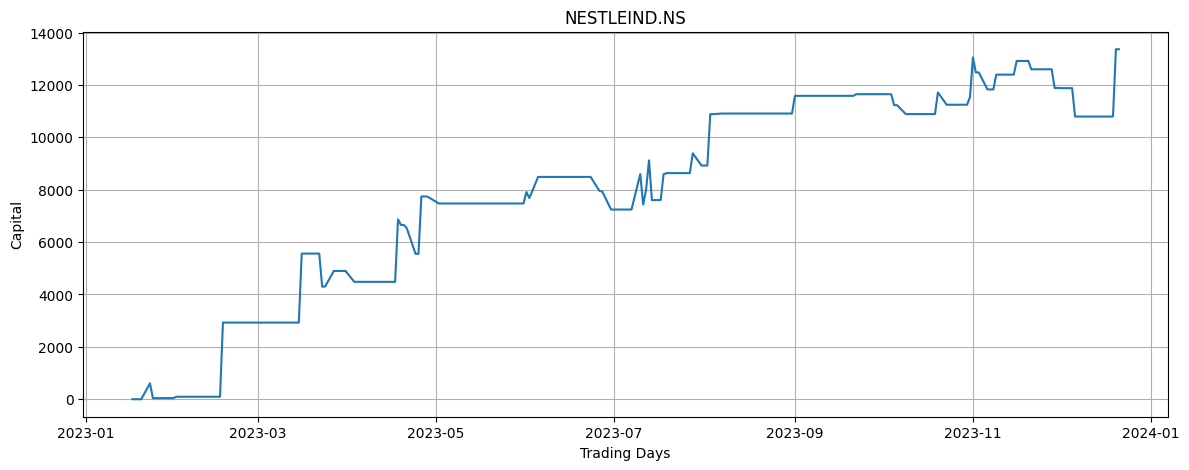

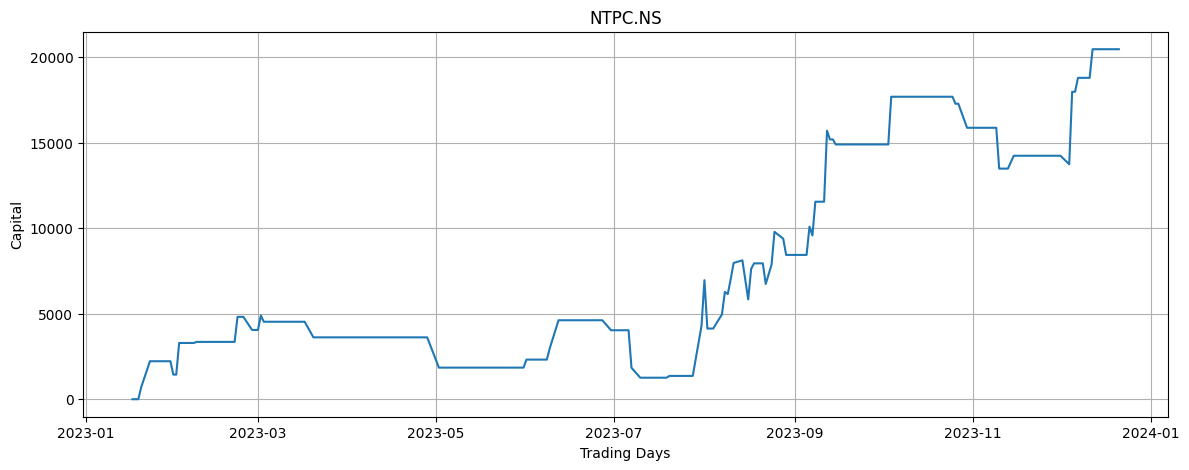

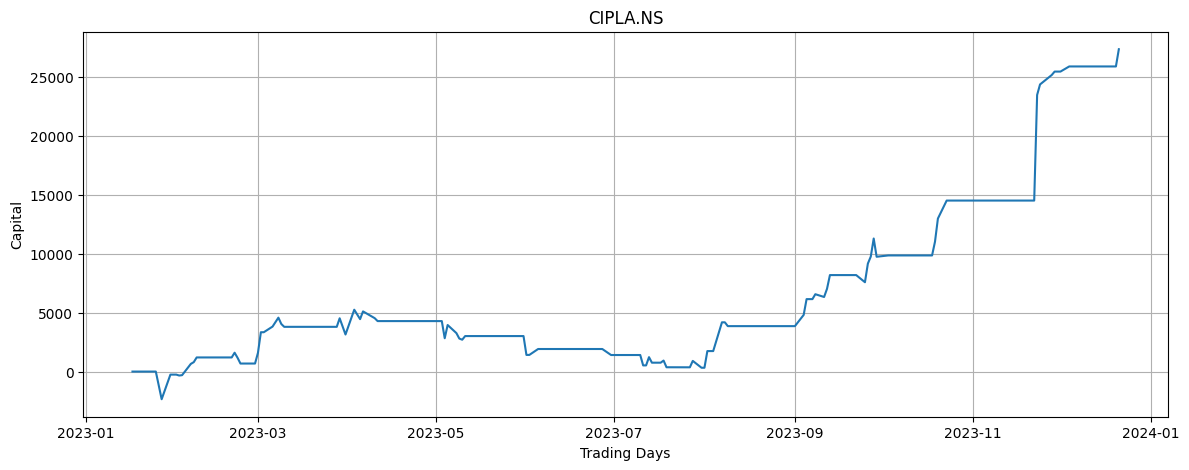

In [ ]:
#Calculating Cumulative Trade Returns and Plotting PnL chart
for stock in stock_list:
  pnl=[]
  pnl.append(0)
  sum=0
  for i in range(0,len(stock_returns[stock])):
    sum+=stock_returns[stock][i]
    pnl.append(sum)

  plt.figure(figsize=(14,5))
  plt.plot(trading_days[t+1:len(trading_days)-1], pnl)
  plt.xlabel("Trading Days")
  plt.ylabel("Capital")
  plt.title(stock)
  plt.grid()
  plt.show()

**Plotting Buy and Sell signals by the Indicator over the Stock price chart**

The green triangle shows the buy signal for that day and the red shows the sell signal for that day in the below graph.

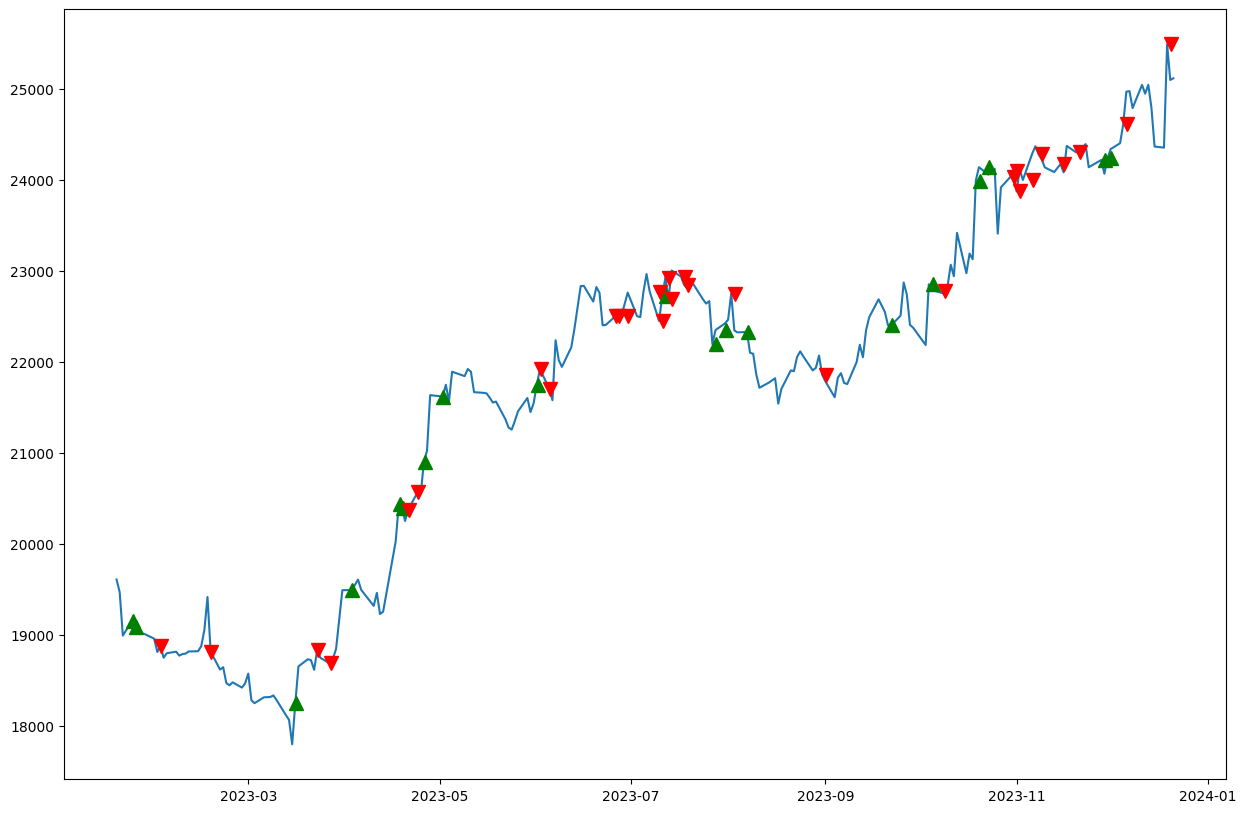

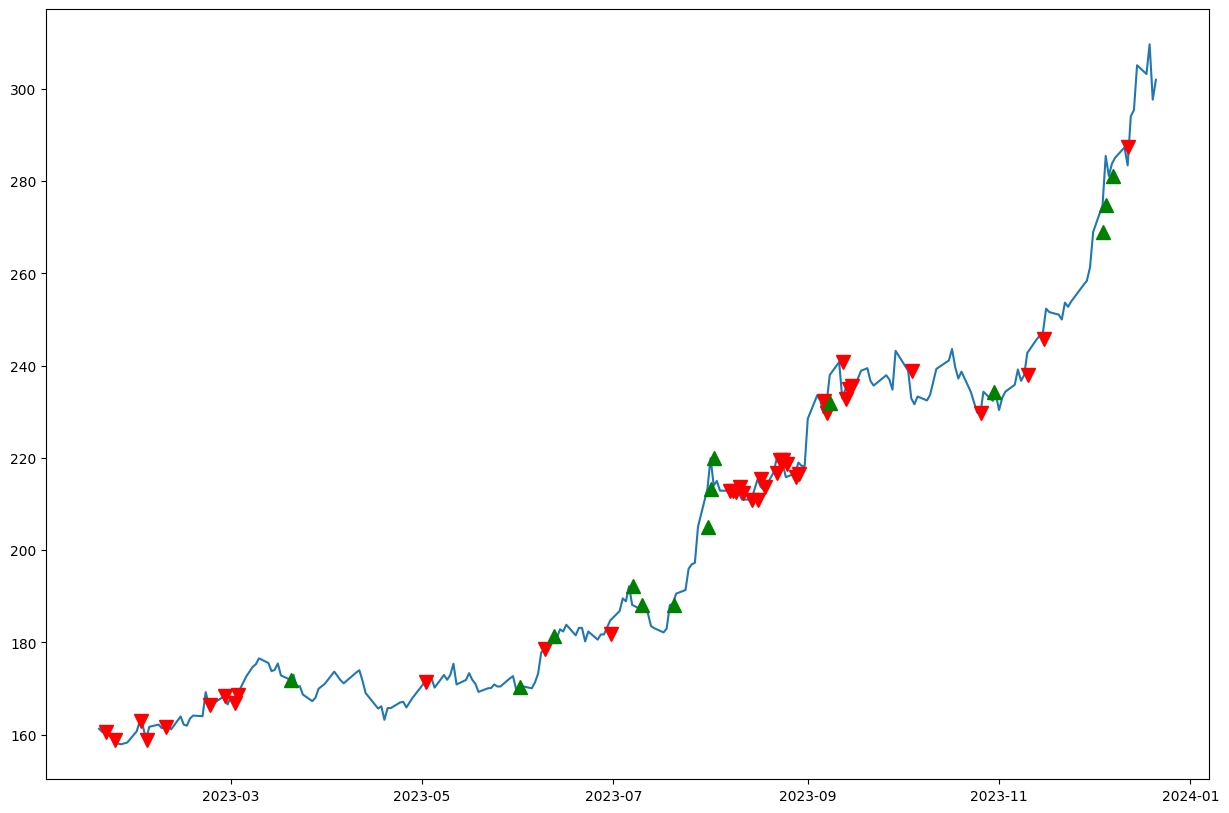

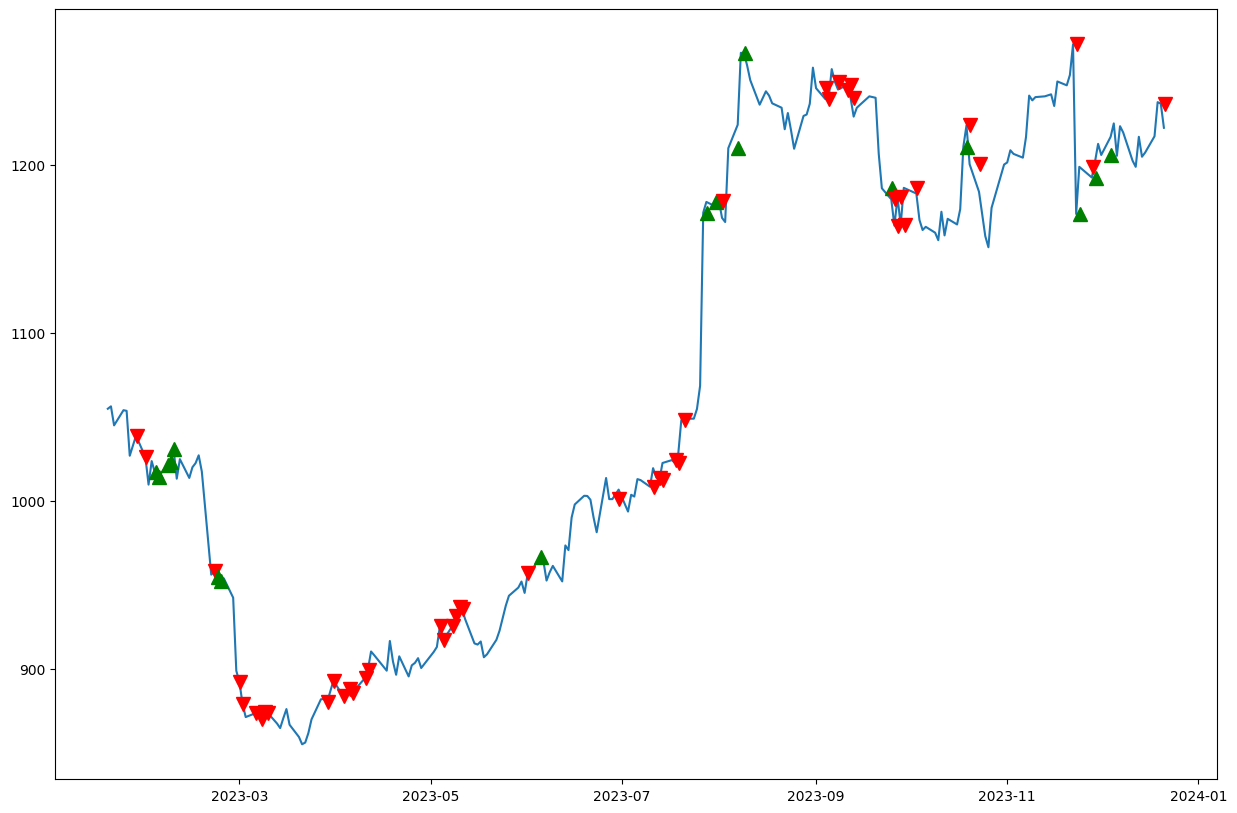

In [ ]:
stock_data_dict = {}
#Calculating Close Data for each stock over the period of trading days
for stock in stock_list:
  start_date = trading_days[t+2]
  end_date = trading_days[len(trading_days)-1]

  ticker = yf.Ticker(stock)
  stock_data_dict[stock] = ticker.history(start=start_date, end=end_date)['Close']

  close = pd.DataFrame(stock_data_dict)

#Plotting Close price and Signals for each stock
for stock in stock_list:
  plt.figure(figsize=(15,10))
  plt.plot(close[stock])
  for i in range(0,len(signal[stock])):
    if(signal[stock][i]==1):
      plt.plot(trading_days[t+2+i],close[stock][i], marker='^',color='g', ms=10) #Buy Signal
    elif(signal[stock][i]==-1):
      plt.plot(trading_days[t+2+i],close[stock][i], marker='v',color='r', ms=10) #Sell Signal
  plt.show()

#Backtesting of the Strategy for RELIANCE over a period of 3 years

In [ ]:
nse = mcal.get_calendar('NSE')

# Show available calendars
#print(mcal.get_calendar_names())
end=date.today()
start=end-timedelta(days=1000)

early = nse.schedule(start_date=start, end_date=end)
trading_days=early.axes[0].tolist()
print(len(trading_days))

675


In [ ]:
stock_list=['RELIANCE.NS']

In [ ]:
initial_capital=100000
portfolio = {}
t=15
for stock in stock_list:
  portfolio[stock] = initial_capital

trading_returns = []
trading_signals=[]

for i in range(t+2,len(trading_days)-1):
  trade_return = {}
  trade_signal = {}
  for stock in stock_list:
    trade_return[stock] = indicator(stock,trading_days,i) * portfolio[stock] * cal_return(stock,trading_days,i)
    trade_signal[stock] = indicator(stock,trading_days,i)
    portfolio[stock] += trade_return[stock]
  trading_signals.append(trade_signal)
  trading_returns.append(trade_return)

stock_returns = pd.DataFrame(trading_returns, index=trading_days[t+2:len(trading_days)-1])
signal = pd.DataFrame(trading_signals, index=trading_days[t+2:len(trading_days)-1])

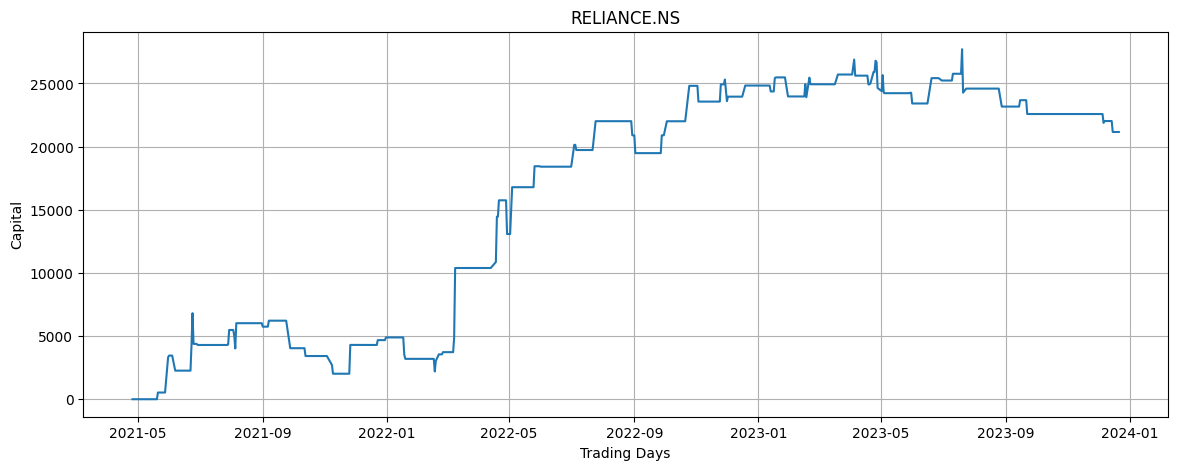

In [ ]:
for stock in stock_list:
  pnl=[]
  pnl.append(0)
  sum=0
  for i in range(0,len(stock_returns[stock])):
    sum+=stock_returns[stock][i]
    pnl.append(sum)

  plt.figure(figsize=(14,5))
  plt.plot(trading_days[t+1:len(trading_days)-1], pnl)
  plt.xlabel("Trading Days")
  plt.ylabel("Capital")
  plt.title(stock)
  plt.grid()
  plt.show()

Comparing Strategy returns with Benchmark returns

In [ ]:
stock_data_dict = {}
for stock in stock_list:
  start_date = trading_days[t+2]
  end_date = trading_days[len(trading_days)-1]

  ticker = yf.Ticker(stock)
  stock_data_dict[stock] = ticker.history(start=start_date, end=end_date)['Close']

  close = pd.DataFrame(stock_data_dict)

for stock in stock_list:
  benchmark_return = ((close[stock][-1] - close[stock][0]) / close[stock][0]) * 100
  print("Benchmark Return is :",benchmark_return)
  sum=0
  for i in range(0,len(stock_returns[stock])):
    sum+=stock_returns[stock][i]

  strategy_return = (sum/initial_capital)*100
  print("Return of our strategy :",strategy_return)


Benchmark Return is : 29.27330387217465
Return of our strategy : 21.16043612910677
